In [10]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research')
from DarkEmuPowerRSD import pkmu_hod
from CovNet import CovNet, CovaPT

In [7]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 49500
N_test = int(N*0.1)
train_log = True
train_correlation = False
train_cholesky = False
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
#training_dir = "/home/jadamo/CovNet/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
#save_dir = "/home/jadamo//CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
#BOSS_dir = "/home/jadamo/CovNet/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"
#CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
net_dir = "../Data/Non-Gaussian/"

k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')

In [18]:
# Chi squared stuff
pgg = pkmu_hod()
params_fid = np.array([67.8,0.1190,0.02215,3.094,2.01,-0.47])
Pk_fid = CovaPT.Pk_gg(params, pgg)
data_vector = np.concatenate([Pk_fid[0], Pk_fid[2]])

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator
Deleted outdated persistence file, no further action needed.
[46744.69230476 65177.428987   67833.43970431 65211.73964528
 60991.16169722 56000.10558407 50552.39702628 45266.46926186
 40656.376626   36920.13240773 34093.86195188 31955.80254592
 30135.11976096 28373.74211392 26514.35616122 24539.72315794
 22573.47175471 20737.83820617 19114.48969238 17735.80484206
 16582.25901414 15615.94997462 14805.02619961 14119.81225124
 13525.17156259 12979.02351697 12445.02636019 11900.54998102
 11341.00676792 10780.69250166 10240.37359161  9735.532657
  9275.16306079  8861.68291153  8491.59412275  8159.90882834
  7860.69199589  7587.15493581  7332.00378651  7089.87247877
  6857.40765914  6632.56154334  6414.97830928  6204.52472755
  6000.86735591  5804.10215704  561

In [8]:
# load the trained network
#net = CovNet.Network_Full(6, 100*100)
net = CovNet.Network_VAE(train_cholesky).to(CovNet.try_gpu());       net.eval()
encoder = CovNet.Block_Encoder().to(CovNet.try_gpu()); encoder.eval()
decoder = CovNet.Block_Decoder(train_cholesky).to(CovNet.try_gpu()); decoder.eval()
net_2 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net.load_state_dict(torch.load(net_dir+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir+'network-features.params'))

<All keys matched successfully>

In [5]:
# load the test set
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_correlation, train_cholesky)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 3.30 s


In [53]:
# get the L1 loss for the matrix -> latent -> matrix and params -> latent -> matrix pipelines
loss_data_1 = np.zeros(N_test)
loss_data_2 = np.zeros(N_test)
net.eval()
for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_actual = test_data[i][1].view(100,100)
    C_reconstruct, mu, log_var = net(C_actual.view(1, 100, 100)); C_reconstruct = C_reconstruct.view(100,100)
    C_predict = decoder(net_2(params).view(1,10)).view(100, 100)
    
    loss_data_1[i] = F.l1_loss(C_reconstruct, C_actual, reduction="sum")
    loss_data_2[i] = F.l1_loss(C_predict, C_actual, reduction="sum")
    
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data), np.amax(loss_data), np.sum(loss_data) / N_test))

100%|██████████████████████████████████████| 4950/4950 [00:31<00:00, 158.11it/s]

min loss: 426.646, max loss 5918.570, avg loss: 2149.611


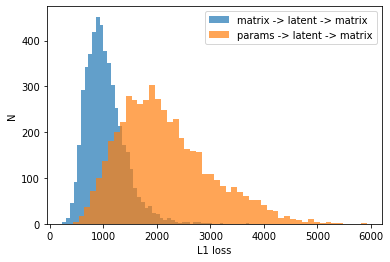

In [54]:
plt.hist(loss_data_1, bins=50, alpha=0.7, label="matrix -> latent -> matrix")#bins=np.logspace(np.log10(np.amin(errors)), np.log10(np.amax(errors)), 50))
plt.hist(loss_data_2, bins=50, alpha=0.7, label="params -> latent -> matrix")
#plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
#plt.xscale("log")

In [21]:
# get the chi squared differences using this network
# This cell takes ~ 1 hour to run
chi_squared_err = np.zeros(N_test)
gaussian_matrices = []
for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_NG_actual = test_data[i][1]
    features = net_2(params); C_NG_predict = decoder(features.view(1,10))
    C_NG_actual = CovNet.symmetric_exp(C_NG_actual).view(100,100)
    C_NG_predict = CovNet.symmetric_exp(C_NG_predict).view(100,100)
    
    with io.capture_output() as captured:
        Pk_galaxy = CovaPT.Pk_gg(params, pgg)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = CovaPT.get_gaussian_covariance(params, pgg, Pk_galaxy)
        gaussian_matrices.append(C_G)
    C_actual = C_G + C_NG_actual.detach().numpy()
    C_predict = C_G + C_NG_predict.detach().numpy()
    
    P_actual = np.linalg.inv(C_actual)
    P_predict = np.linalg.inv(C_predict)
    
    # if train_cholesky or train_correlation:
    #     if train_cholesky:
    #         prediction = torch.matmul(CovNet.symmetric_exp(prediction), torch.t(CovNet.symmetric_exp(prediction)))
    #         matrix = torch.matmul(CovNet.symmetric_exp(matrix), torch.t(CovNet.symmetric_exp(matrix)))
    #     elif train_correlation:
    #         prediction = CovNet.corr_to_cov(prediction)
    #         matrix = CovNet.corr_to_cov(matrix)
    #     perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
    #     perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    # else:
    #     perc_predict = torch.linalg.inv(CovNet.symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
    #     perc_actual  = torch.linalg.inv(CovNet.symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
    
    x = data_vector - model_vector
    chi_squared_1 = np.matmul(x.T, np.matmul(P_predict, x))
    chi_squared_2 = np.matmul(x.T, np.matmul(P_actual, x))
    chi_squared_err[i] = abs(chi_squared_1 - chi_squared_2)
    
print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(np.amin(chi_squared_err), np.amax(chi_squared_err), np.mean(chi_squared_err))

100%|███████████████████████████████████████| 4950/4950 [51:52<00:00,  1.59it/s]

chi squared absolute errors: [0.00, 9459245.51], avg = 6189.133


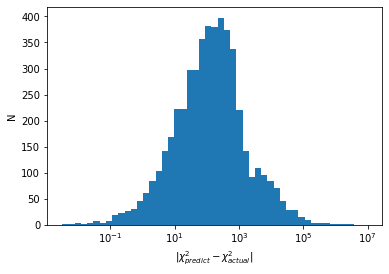

In [26]:
plt.hist(chi_squared_err, bins=np.logspace(np.log10(np.amin(chi_squared_err[(chi_squared_err != 0)])), np.log10(np.amax(chi_squared_err)), 50))
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

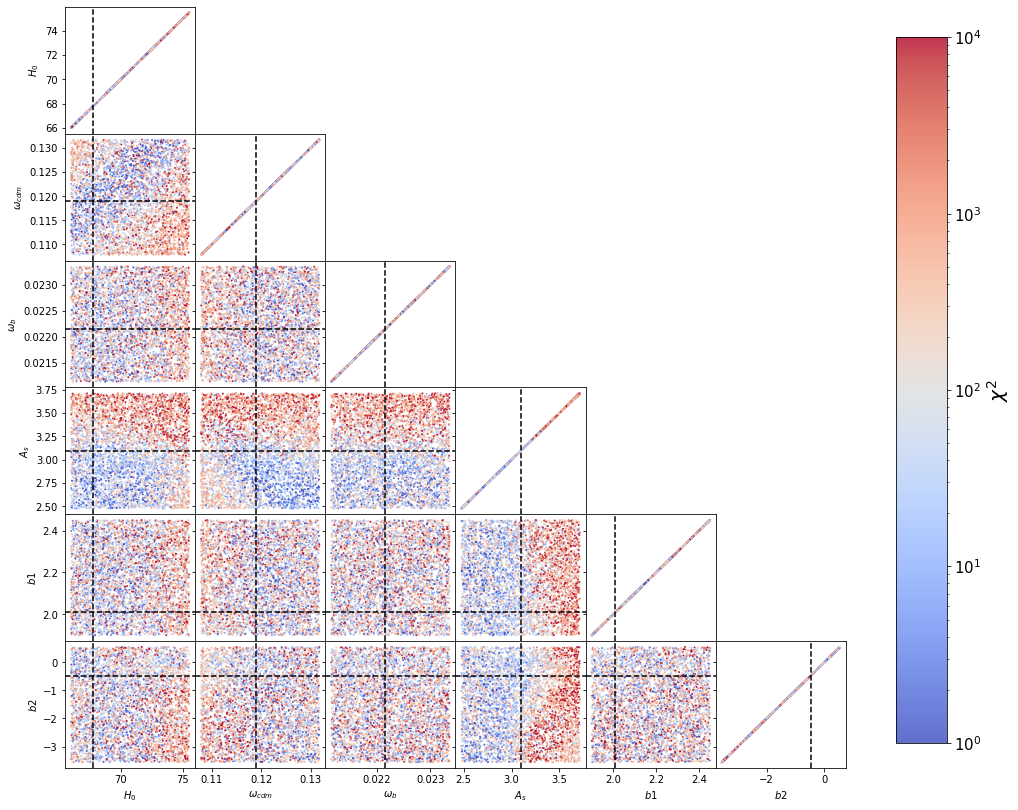

In [107]:
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

names = ['H0', 'omch2', 'ombh2', "As", "b1", "b2", "chi_squared"]
labels= [r"$H_0$", r'$\omega_{cdm}$', r'$\omega_b$', r"$A_s$", "$b1$", "$b2$", r"$\chi^2$"]

params = test_data[:][0].detach().numpy()
fig, axs = plt.subplots(6,6, figsize=(14,14))
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        #X, Y, Z = make_heatmap(params[:,j], params[:,i], chi_squared_err, 30)
        #img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap="coolwarm", 
        #                     norm=colors.LogNorm(vmin=1e-1, vmax=1e5))
        img = axs[i][j].scatter(params[:,j], params[:,i], c=chi_squared_err, s=1, alpha=0.8, cmap="coolwarm",
                          norm=colors.LogNorm(vmin=1e-0, vmax=1e4))
        if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
        axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label(labels[-1] ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

Indexes: 611 4316


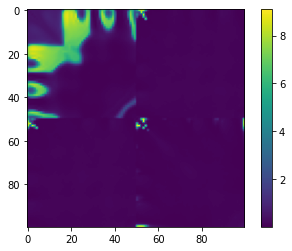

In [7]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

loss =  2828.66455078125
rediction = 1258.402, KL Divergence = 1570.263
sample 4500, params: tensor([ 7.4717e+01,  1.1925e-01,  2.2866e-02,  3.6004e+00,  2.4183e+00,
        -1.4099e+00])


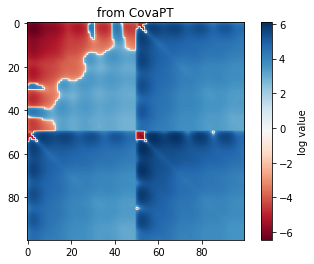

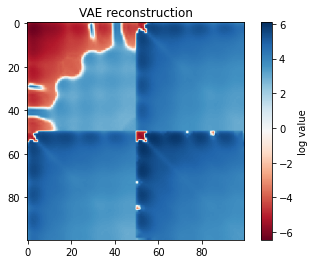

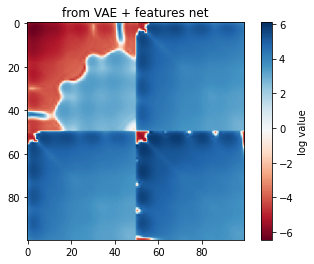

In [111]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = test_data[idx][1]
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", CovNet.VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

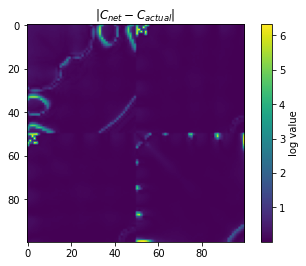

In [13]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

idx =  100
0.9974409 [0.913754   0.0483785  0.02873703 0.00462756 0.00194381]
[88.669464 97.86662  96.322334 39.820248 20.701097]


Text(0, 0.5, 'PC 2')

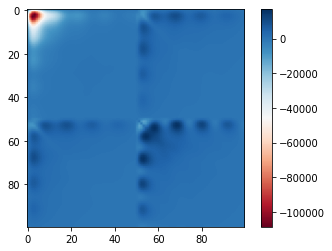

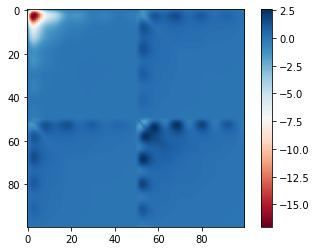

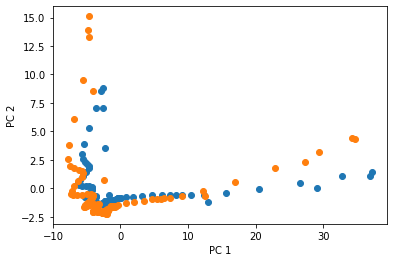

In [31]:
# do a PCA of this matrix
#idx = np.random.randint(0, N_test)
idx = 100
print("idx = ", idx)
C_actual = CovNet.symmetric_exp(test_data[idx][1]).view(100, 100).detach().numpy()
features = net_2(params); C_predict = CovNet.symmetric_exp(decoder(features.view(1,10))).view(100, 100).detach().numpy()

plt.figure()
plt.imshow(C_actual, cmap="RdBu")
plt.colorbar()

C_actual = (C_actual - np.mean(C_actual)) / np.std(C_actual)
C_predict = (C_predict - np.mean(C_predict)) / np.std(C_predict)

pca = PCA(n_components = 6)
pca.fit(C_actual) #<- calculates the principal axes of the given data
components = pca.transform(C_actual)
components_2 = pca.transform(C_predict)

plt.figure()
plt.imshow(C_actual, cmap="RdBu")
plt.colorbar()

print(np.sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)

pca_diff = np.sum(abs(components_2 - components), axis=0)
print(pca_diff)

plt.figure()
plt.scatter(components[:,0], components[:,1])
plt.scatter(components_2[:,0], components_2[:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")

In [18]:
# Test for positive definite-ness
pos_diag = True
for i in range(cov_predict.shape[0]):
    if cov_predict[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

diagonal is all positive: True


tensor(0.)


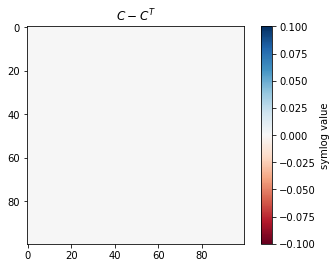

In [31]:
cov_predict2 = cov_predict.to(CovNet.try_gpu())
cov_sym = (CovNet.symmetric_exp(cov_predict2) + CovNet.symmetric_exp(torch.t(cov_predict2)))
cov_asym = (CovNet.symmetric_exp(cov_predict2) - CovNet.symmetric_exp(torch.t(cov_predict2)))
symmetric_val = torch.linalg.norm(cov_asym, 2) / torch.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.figure()
plt.title(r"$C - C^T$")
#plt.imshow(cov_test2 - cov_test2.T, cmap="RdBu")
plt.imshow(cov_asym.cpu(), cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("symlog value")

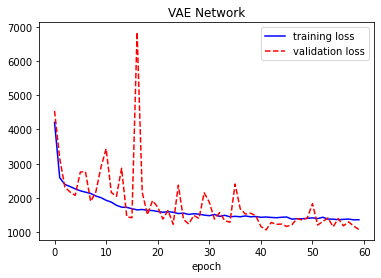

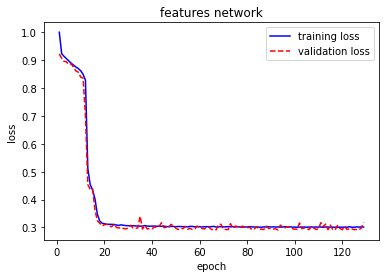

In [108]:
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-features.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-features.dat")

epoch = range(len(train_loss))
plt.title("VAE Network")
plt.plot(epoch, train_loss, color="blue", label="training loss")
plt.plot(epoch, valid_loss, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.ylim(800, 4000)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f))
plt.figure()
plt.title("features network")
plt.plot(epoch_f[1:], train_loss_f[1:], color="blue", label="training loss")
plt.plot(epoch_f[1:], valid_loss_f[1:], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend()

In [109]:
# try to visualize the feature space
features = torch.zeros(N, 10, device=CovNet.try_gpu())
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    z, mu, log_var = encoder(matrix.view(1, 100, 100))
    features[i] = z
    
features = features.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 0 minutes 9.96 seconds


[0.46605504 0.6991991  0.3768368  0.4293065  0.58371854 0.9380628
 0.5986519  0.9044355  0.74663424 0.47521207]


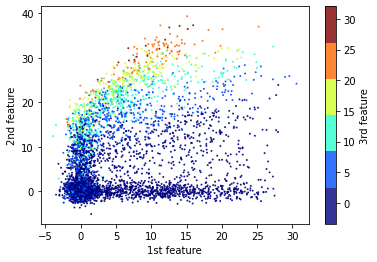

In [110]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

print(np.mean(features, axis=0))
f1 = 0; f2 = 1; f3 = 2
plt.scatter(features[:,f1], features[:,f2], cmap=cmap, c=features[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
cbar = plt.colorbar()
cbar.set_label("3rd feature")

## Extra tests for debugging

Covariance matrix is NOT positive-definite!
1 [ 9.24216640e+08  4.57185440e+08  3.45549152e+08  2.00713856e+08
  1.40470880e+08  7.95024240e+07  7.45302080e+07  4.10885800e+07
  3.55686080e+07  2.38220320e+07  1.81468980e+07  1.44928190e+07
  9.77248800e+06  9.29729800e+06  6.42127050e+06  5.31957850e+06
  4.51185350e+06  3.27843550e+06  3.11896875e+06  2.37967575e+06
  1.90942788e+06  1.74812750e+06  1.34205588e+06  1.20571150e+06
  1.02206781e+06  8.35322500e+05  7.89321375e+05 -5.00642562e+05
  6.45776562e+05  5.68982062e+05  5.21911281e+05  4.33298438e+05
  4.00994188e+05  3.50148156e+05  2.99476625e+05  2.80302781e+05
  2.35199891e+05  2.19241016e+05  1.91911797e+05  1.73402812e+05
  1.58563656e+05  1.39448891e+05  1.31221812e+05  1.19167141e+05
  1.06719875e+05  1.03083938e+05  9.19162266e+04  8.37254453e+04
  8.07970078e+04  7.08451094e+04  6.75910859e+04  6.19720977e+04
  5.49492383e+04  5.45381172e+04  4.83150234e+04  4.53006289e+04
  4.32953594e+04  3.91388359e+04  3.75385273

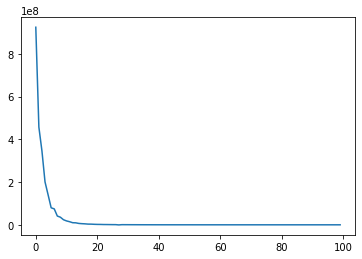

In [28]:
params_bad = torch.tensor([74.65041619539261, 0.1152447252368927, 0.0228745732113719, 3.696852154016495, 1.9854176259040832,-2.1415713782310486])
features = net_2(params_bad); C_bad = decoder(features.view(1,10)).view(100, 100)
C_bad = CovNet.corr_to_cov(C_bad).detach().numpy()

try:
    L = np.linalg.cholesky(C_bad)
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")

eigen, v = np.linalg.eig(C_bad)
print(len(eigen[(eigen < 0)]), eigen)
plt.plot(range(100), eigen)

In [39]:
# test to see what outputs from the training / validation sets looks like
# I'm only loading in a subset of the whole training set to save memory / time
t1 = time.time()
train_data = MatrixDataset(training_dir, int(N*0.1), 0, train_log, train_correlation, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 22.98 s


loss =  114.20138549804688
rediction = 29.388, KL Divergence = 84.813
sample 127, params: tensor([6.7463e+01, 3.0175e-01, 1.1845e-01, 1.8676e-09, 1.9195e+00, 4.2772e-01],
       device='cuda:0')


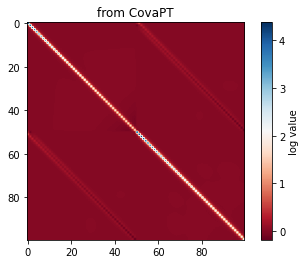

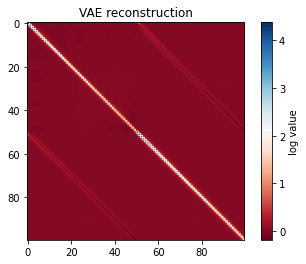

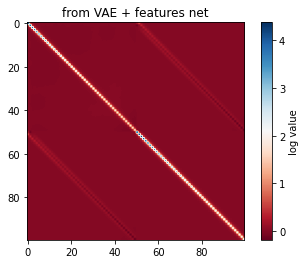

In [40]:
idx = np.random.randint(0, N*0.1)
params = train_data[idx][0]
# matrix from CovaPT
cov_actual = train_data[idx][1]

cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

Indexes: 1328 3497


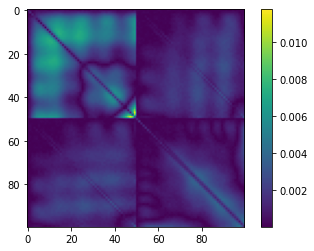

In [41]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N*0.1); idx2 = np.random.randint(0, N*0.1)
params1 = train_data[idx1][0]; params2 = train_data[idx2][0]
cov_actual1 = train_data[idx1][1]; cov_actual2 = train_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()